In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import gc
import regex as re
import spacy
import xgboost
import lightgbm
import catboost
import itertools
import numpy as np
import pandas as pd
import codecs,string
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import model_selection
from tqdm import tqdm_notebook as tqdm
from sklearn import metrics, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

gc.enable()

In [3]:
class config:
    TARGET = 'target'
    NUM_FOLDS = 10
    JUNK = -9999
    SEED = 3407
    USE_TfIdf = True
    MAX_FEATURES = 2500
    USE_spacy = True

In [4]:
def create_folds(df):
    
    data = df[['video_id', 'target']]
    data = pd.DataFrame(df.groupby('video_id')['target'].mean()).reset_index()
    
    data = data.dropna().reset_index()
    
    data['kfold'] = -1
    
    num_bins = int(np.floor(1 + np.log2(len(data))))
    data.loc[:, "bins"] = pd.cut(
        data[config.TARGET], bins=num_bins, labels=False
    )
    
    kf = model_selection.StratifiedKFold(n_splits=config.NUM_FOLDS, shuffle=True, random_state=config.SEED)
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
        
    data = data.drop(["bins", "target"], axis=1)
    
    df = df.merge(data, on='video_id', how='left').drop('index', axis=1)
    
    del data
    gc.collect()
    
    return df

In [5]:
def is_arabic(character):
    maxchar = max(character)
    if u'\u0627' <= maxchar <= u'\u064a':
        return True
    else:
        return False
    
#korean
def is_hangul(value):
    if re.search(r'\p{IsHangul}', value):
        return True
    return False

# referred to https://stackoverflow.com/questions/10809176/regular-expressions-regex-in-japanese 
#Japanese
def is_japanese(value):
    if re.search(r'[\p{Hiragana}\p{Katakana}\p{Han}\p{Latin}]', value):
        return True
    return False


def is_hindi(character):
    maxchar = max(character)
    if u'\u0900' <= maxchar <= u'\u097f':
        return True
    else:
        return False

In [6]:
def basic_preprocess(train_data, test_data):
    test_data[config.TARGET] = config.JUNK
    data = pd.concat([train_data, test_data]).reset_index(drop=True)

    cat_cols = ['video_id', 'channelId', 'categoryId', 'comments_disabled', 'ratings_disabled']
    num_cols = ['duration_seconds']
    date_cols = ['publishedAt', 'trending_date']
    
    drop_cols = ['id']
    
    # -------------  CATEGORICAL COLUMNS  ------------- #
    # encoding
    print('Label Encoding...')
    for col in cat_cols:
        data[col].fillna('NONE', inplace=True)
        enc = preprocessing.LabelEncoder()
        data[col] = enc.fit_transform(data[col])
        data[col] = data[col].astype('category')

    # -------------  NUMERIC COLUMNS  ------------- #
    # Min max scaling
    print('Normalising num cols...')
    for col in num_cols:
        # data[col].fillna(data[col].mean(), inplace=True)
        data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
        
#     num_bins = int(np.floor(1 + np.log2(len(data))))
#     data.loc[:, "duration_seconds_bins"] = pd.cut(
#         data["duration_seconds"], bins=num_bins, labels=False
#     )

    # ------- Date Time cols ------ 
    print('Date time cols...')
    for col in date_cols:
        data[col] = pd.to_datetime(data[col], utc=True)
        data.loc[:, col + '_year'] = (data[col].dt.year).astype('category')
        data.loc[:, col + '_weekofyear'] = (data[col].dt.weekofyear).astype('category')
        data.loc[:, col + '_month'] = (data[col].dt.month).astype('category')
        data.loc[:, col + '_dayofweek'] = (data[col].dt.dayofweek).astype('category')
        data.loc[:, col + '_weekend'] = ((data[col].dt.weekday >=5).astype(int)).astype('category')
        drop_cols.append(col)
    

    data['video_age'] = (data['trending_date'] - data['publishedAt'])\
                        .dt.days.astype('int')\
                        .replace({-1: 0}).value_counts()
    
    
    # --------Rob Features -------- #
    data['channel_occurance'] = data['channelId'].map(
        data['channelId'].value_counts().to_dict())

    data['channel_unique_video_count'] = data['channelId'].map(
        data.groupby('channelId')['video_id'].nunique().to_dict())
    
    data['video_occurance_count'] = data.groupby('video_id')['trending_date'].rank().astype('int')
   
    
    # ------- Text columns -------
    print('Text stuff')
    data['text'] = data['channelTitle']\
            + ' ' + data['title'] \
            + ' ' + data['description'].fillna(' ').apply(lambda x: re.sub(r'http\S+', ' ', x))\
            + ' ' + data['tags'].apply(lambda x: x.replace('|', ' ').replace('[None]', ''))
    
    data['num_words'] = data['text'].apply(lambda x: len(x.split()))
    data['num_characters'] = data['text'].apply(lambda x: len(x))
    
    drop_cols += ['channelTitle', 'title', 'description', 'tags']
    drop_cols += ['thumbnail_link', 'has_thumbnail']
    drop_cols += ['isTest']
    drop_cols += ['view_count', 'likes', 'dislikes', 'comment_count',]

    #  ----------- New Features ---------------------------------------
    data['Friday_Trending'] = [1 if a == 4 else 0 for a in data.trending_date_dayofweek]
    data['Thursday_Trending'] = [1 if a == 3 else 0 for a in data.trending_date_dayofweek]
    data['Friday_Published'] = [1 if a == 4 else 0 for a in data.publishedAt_dayofweek]
    data['Sunday_Published'] = [1 if a == 6 else 0 for a in data.publishedAt_dayofweek]
    data['duration_missing'] = data.duration_seconds.isna()
    data['short_video'] = [1 if a<=60 else 0 for a in data.duration_seconds]
    data['isArabic'] = [is_arabic(a) for a in data.tags]
    data['isKorean'] = [is_hangul(a) for a in data.tags]
    data['isJapanese'] = [is_japanese(a) for a in data.tags]
    data['isHindi'] = [is_hindi(a) for a in data.tags]
    
    
    data.drop(drop_cols, axis=1, inplace=True)
    
    train_data = data[data[config.TARGET] != config.JUNK].reset_index(drop=True)
    test_data = data[data[config.TARGET] == config.JUNK].reset_index(drop=True)
    test_data.drop([config.TARGET], axis=1, inplace=True)
    
    print('Done!!!')
    return train_data, test_data

In [7]:
def spacy_features(text):
    
    nlp = spacy.load('en_core_web_lg')
    with nlp.disable_pipes():
        spacy.prefer_gpu()
        vectors = np.array([nlp(t).vector for t in tqdm(text)])
    
    vectors = pd.DataFrame(vectors, columns=[f'spacy_{i}' for i in range(300)])
        
    return vectors

In [8]:
def vectorize(train_text, test_text):
    vectorizer = TfidfVectorizer(max_features=config.MAX_FEATURES, ngram_range=(1, 2), stop_words='english')
    
    train_vectors = vectorizer.fit_transform(train_text).toarray() 
    test_vectors = vectorizer.transform(test_text).toarray()
    
    return train_vectors, test_vectors

In [9]:
model_dispatcher = {
    'lgbm': lightgbm.LGBMRegressor(n_estimators=2000),
    'catboost': catboost.CatBoostRegressor(n_estimators=2000, max_depth=10, verbose=0, task_type='GPU'),
    'xgb': xgboost.XGBRegressor(n_estimators=2000, verbosity=0, tree_method='gpu_hist')
}

In [10]:
def get_score(y_true, y_preds):
    return round(
        metrics.mean_absolute_error(y_true, y_preds),
        5
    )


def train_fn(data, fold, model_name, test_data):
    train_data = data[data['kfold'] != fold].reset_index(drop=True)
    valid_data = data[data['kfold'] == fold].reset_index(drop=True)
    
    x_train = train_data.drop(['kfold', config.TARGET], axis=1)
    y_train = train_data[config.TARGET]
    
    x_valid = valid_data.drop(['kfold', config.TARGET], axis=1)
    y_valid = valid_data[config.TARGET]
    
    model = model_dispatcher[model_name]
    
    model.fit(x_train, y_train, cat_features=CAT_COLS_CATBOOST)
    y_preds = model.predict(x_valid)
    y_train_preds = model.predict(data.drop(['kfold', config.TARGET], axis=1))
    
    score = get_score(y_valid, np.abs(y_preds))
    print(f'Fold: {fold}, Score: {score}')
    
    y_test = model.predict(test_data)

    
    if fold ==0:
        fi = pd.DataFrame({'feature_importance': model.get_feature_importance(catboost.Pool(x_valid, label=y_valid,cat_features=CAT_COLS_CATBOOST)), 
              'feature_names': x_valid.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
        fi.plot(x = 'feature_names', y = 'feature_importance',  kind='barh', figsize=(12, 8),
                                      title='Feature Importance')
        plt.show()
        
    del model
    del train_data, valid_data
    del x_train, y_train, x_valid, y_valid
    del test_data, y_preds
    gc.collect()
    
    return score, y_test, y_train_preds

In [11]:
df = pd.read_parquet('../input/kaggle-pog-series-s01e01/train.parquet') # .sample(100)
test = pd.read_parquet('../input/kaggle-pog-series-s01e01/test.parquet') # .sample(100)

sub = test[['id']]

In [12]:
train, test = basic_preprocess(df, test)

Label Encoding...
Normalising num cols...
Date time cols...
Text stuff
Done!!!


In [13]:
train.shape

(92275, 34)

In [14]:
CAT_COLS_CATBOOST = [
    'channelId',
    'categoryId',
    'publishedAt_year',
    'publishedAt_weekofyear',
    'publishedAt_month',
    'publishedAt_dayofweek',
    'publishedAt_weekend',
    'trending_date_year',
    'trending_date_weekofyear',
    'trending_date_month',
    'trending_date_dayofweek',
    'Friday_Trending',
    'Friday_Published',
    'isKorean']

In [15]:
train_text = train.text.tolist()
test_text = test.text.tolist()

train.drop(['text',], axis=1, inplace=True)
test.drop(['text',], axis=1, inplace=True)

In [16]:
if config.USE_TfIdf:
    print('vectorizing...')
    
    train_vectors, test_vectors = vectorize(train_text, test_text)
    
    pca = decomposition.PCA(n_components=500, random_state=config.SEED)
    print("Fitting PCA...")
    pca.fit(train_vectors)
    train_projection = pca.transform(train_vectors)
    test_projection = pca.transform(test_vectors)
    
    train_vectors = pd.DataFrame(train_projection)
    train_vectors.columns = [f'cat_{i}' for i in range(train_vectors.shape[1])]

    test_vectors = pd.DataFrame(test_projection)
    test_vectors.columns = [f'cat_{i}' for i in range(test_vectors.shape[1])]
    
    train = pd.concat([train, train_vectors], axis=1)
    test = pd.concat([test, test_vectors], axis=1)
    
    print('done!')
    
gc.collect()

vectorizing...
Fitting PCA...
done!


30

In [17]:
if config.USE_spacy:
    train_spacy_features = pd.read_csv('../input/pog001-spacy-features/train_spacy_features.csv') # .drop(['target'], axis=1)
    test_spacy_features = pd.read_csv('../input/pog001-spacy-features/test_spacy_features.csv') # .drop(['target'], axis=1)

    train = pd.concat([train, train_spacy_features], axis=1)
    test = pd.concat([test, test_spacy_features], axis=1)

    del train_spacy_features, test_spacy_features
    gc.collect()

In [18]:
train = train[train['ratings_disabled'] == 0].reset_index(drop=True)
train.drop(['ratings_disabled'], axis=1, inplace=True)
test.drop(['ratings_disabled'], axis=1, inplace=True)

In [19]:
train_folds = create_folds(train)

In [20]:
useless = ['video_id','isArabic','duration_missing','isJapanese','short_video','trending_date_weekend','isHindi','Thursday_Trending','comments_disabled','Sunday_Published']
features = [i for i in train_folds.columns if i not in useless]
train_folds = train_folds[features]
features = [i for i in test.columns if i not in useless]
test = test[features]

In [21]:
train_folds.head()

,channelId,categoryId,duration_seconds,target,publishedAt_year,publishedAt_weekofyear,publishedAt_month,publishedAt_dayofweek,publishedAt_weekend,trending_date_year,...,spacy_291,spacy_292,spacy_293,spacy_294,spacy_295,spacy_296,spacy_297,spacy_298,spacy_299,kfold
0,4508,7,NaN,0.103596,2020,33,8,1,0,2020,...,-0.002529,-0.060508,-0.002594,0.127825,-0.029619,0.003280,-0.016495,-0.008726,0.106308,2
1,115,6,NaN,0.061611,2020,33,8,1,0,2020,...,-0.075823,-0.166156,-0.039034,-0.069062,0.031587,-0.018785,-0.003276,0.075232,0.034280,7
2,2734,9,NaN,0.173523,2020,33,8,1,0,2020,...,0.037210,0.031576,0.054045,0.137317,-0.021773,-0.030770,-0.083969,-0.128467,0.229208,2
3,3016,2,NaN,0.046804,2020,33,8,1,0,2020,...,0.006147,0.032810,0.017815,0.074406,-0.019042,-0.109596,-0.061865,-0.051815,0.020958,5
4,1110,11,NaN,0.040753,2020,33,8,1,0,2020,...,-0.000403,-0.016457,0.010130,0.006342,-0.022810,0.000107,-0.059409,-0.054310,0.033589,2


catboost


  0%|          | 0/10 [00:00<?, ?it/s]

Fold: 0, Score: 0.01493


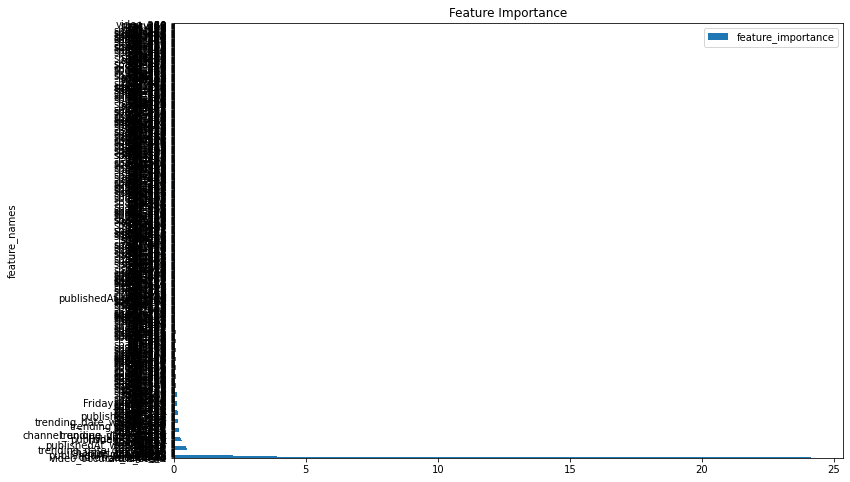

Fold: 1, Score: 0.01428
Fold: 2, Score: 0.01416
Fold: 3, Score: 0.01425
Fold: 4, Score: 0.01493
Fold: 5, Score: 0.01481
Fold: 6, Score: 0.01438
Fold: 7, Score: 0.01395
Fold: 8, Score: 0.01434
Fold: 9, Score: 0.01451
Average Score: 0.01445



In [22]:
models = [
    'catboost'
]

all_test_preds = {}
all_train_preds = {}

# train_folds[CAT_COLS_CATBOOST] = train_folds[CAT_COLS_CATBOOST].astype(int)
# test[CAT_COLS_CATBOOST] = test[CAT_COLS_CATBOOST].astype(int)

for model_name in models:
    print(model_name)
    score_sum = 0
    test_preds = np.zeros((len(test)))
    train_preds = np.zeros((len(train_folds)))
    
    for fold in tqdm(range(config.NUM_FOLDS)):
        score, current_test_preds, current_train_preds = train_fn(train_folds, fold, model_name, test)  
        score_sum += score
        test_preds += current_test_preds
        train_preds += current_train_preds
    
    all_test_preds[model_name] = test_preds / config.NUM_FOLDS
    all_train_preds[model_name] = train_preds / config.NUM_FOLDS
    
    print(f'Average Score: {round(score_sum / config.NUM_FOLDS, 5)}')
    print()

In [23]:
sub = pd.read_parquet('../input/kaggle-pog-series-s01e01/test.parquet')
sub['target'] = np.abs(all_test_preds['catboost'])

sub['mask_for_pp'] = (sub['ratings_disabled'] == False) * 1
sub['target'] = sub['target'] * sub['mask_for_pp']

sub[['id', 'target']].to_csv('submission1.csv', index=False)